In [1]:
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 

    98% |███████████████████████████████▋| 584.4MB 46.9MB/s eta 0:00:01

    100% |████████████████████████████████| 592.3MB 31.6MB/s 


In [2]:
!pip3 install torchvision

    100% |████████████████████████████████| 61kB 2.3MB/s 
    100% |████████████████████████████████| 2.0MB 7.5MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [0]:
# Required Header Files
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt


In [0]:
# Class for Normal Distribution
class Normal(object):
    def __init__(self, mu, sigma, log_sigma, v=None, r=None):
        self.mu = mu
        self.sigma = sigma  # either stdev diagonal itself, or stdev diagonal from decomposition
        self.logsigma = log_sigma
        dim = mu.get_shape()
        if v is None:
            v = torch.FloatTensor(*dim)
        if r is None:
            r = torch.FloatTensor(*dim)
        self.v = v
        self.r = r

In [0]:
# Encoder class consisting of 2 linear layers
class Encoder(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Encoder, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)
    # Forward pass function
    def forward(self, x):
        x = F.relu(self.linear1(x))
        return F.relu(self.linear2(x))

In [0]:
 # Decoder Classc consisting of 2 linear layers symmetrical to the Encoder
class Decoder(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Decoder, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)
    # Forward pass function
    def forward(self, x):
        x = F.relu(self.linear1(x))
        return F.relu(self.linear2(x))


In [0]:
# Variational Auto Encoder class
class VAE(torch.nn.Module):
    latent_dim = 8 # Hyper - Parameter which can be later tuned
    
    # Constructor function for the Variational Auto Encoder
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder # An Encoder
        self.decoder = decoder # A Decoder
        self._enc_mu = torch.nn.Linear(100, 8)  # Mean
        self._enc_log_sigma = torch.nn.Linear(100, 8) # Log Std Deviation
        
       
    # Sampling Function
    def _sample_latent(self, h_enc):
        """
        Return the latent normal sample z ~ N(mu, sigma^2)
        """
        mu = self._enc_mu(h_enc)
        log_sigma = self._enc_log_sigma(h_enc)
        sigma = torch.exp(log_sigma)
        std_z = torch.from_numpy(np.random.normal(0, 1, size=sigma.size())).float()

        self.z_mean = mu
        self.z_sigma = sigma

        return mu + sigma * Variable(std_z, requires_grad=False)  # Reparameterization trick
    # Forward Pass Function
    def forward(self, state):
        h_enc = self.encoder(state)
        z = self._sample_latent(h_enc)
        return self.decoder(z)



In [0]:
# Function to calculate Latent Loss
def latent_loss(z_mean, z_stddev):
    mean_sq = z_mean * z_mean
    stddev_sq = z_stddev * z_stddev
    return 0.5 * torch.mean(mean_sq + stddev_sq - torch.log(stddev_sq) - 1)



Processing...
Done!
Number of samples:  60000
0 0.06542827934026718
1 0.06842564791440964
2 0.07225073873996735
3 0.0666666179895401
4 0.0651979073882103
5 0.07221096754074097
6 0.059068262577056885
7 0.06676647067070007
8 0.0694689229130745
9 0.06773657351732254
10 0.066789411008358
11 0.07382402569055557
12 0.0663641095161438
13 0.06821306049823761
14 0.06740333884954453
15 0.07181020826101303
16 0.06951093673706055
17 0.07425732165575027
18 0.06882365792989731
19 0.0683014988899231
20 0.07120612263679504
21 0.06374897062778473
22 0.0691245049238205
23 0.0674884170293808
24 0.07167474180459976
25 0.06827016919851303
26 0.06994721293449402
27 0.06811806559562683
28 0.0673644170165062
29 0.0659450888633728
30 0.06767313927412033
31 0.06886132061481476
32 0.06857798248529434
33 0.06544660031795502
34 0.0727199837565422
35 0.06401597708463669
36 0.06678040325641632
37 0.06609135121107101
38 0.06844674050807953
39 0.06947821378707886
40 0.061921533197164536
41 0.06765604019165039
42 0.070

79 0.06346061080694199
80 0.07050180435180664
81 0.06437322497367859
82 0.06957194209098816
83 0.0688934326171875
84 0.07204177230596542
85 0.06611320376396179
86 0.06474726647138596
87 0.06333782523870468
88 0.06352560967206955
89 0.061358191072940826
90 0.06986640393733978
91 0.06939544528722763
92 0.059986915439367294
93 0.06659296154975891
94 0.06321022659540176
95 0.06904921680688858
96 0.06783326715230942
97 0.06502271443605423
98 0.06741303950548172
99 0.06863559782505035


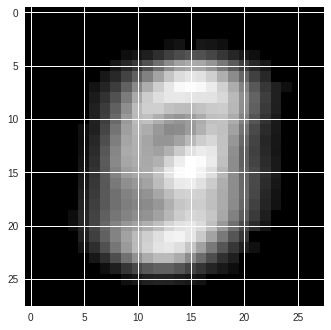

In [9]:
if __name__ == '__main__':
    
    input_dim = 28 * 28
    batch_size = 32

    transform = transforms.Compose(
        [transforms.ToTensor()])
    mnist = torchvision.datasets.MNIST('./', download=True, transform=transform)

    dataloader = torch.utils.data.DataLoader(mnist, batch_size=batch_size,
                                             shuffle=True, num_workers=2)

    print('Number of samples: ', len(mnist))
    # Intialization of the Encoder and the Decoder
    encoder = Encoder(input_dim, 100, 100)
    decoder = Decoder(8, 100, input_dim)
    vae = VAE(encoder, decoder)
    # Using Mean Squared Loss for training
    criterion = nn.MSELoss()
    # Using Adam Optimizer
    optimizer = optim.Adam(vae.parameters(), lr=0.0001)
    l = None
    # Training for 100 iterations
    for epoch in range(100):
        for i, data in enumerate(dataloader, 0):
            inputs, classes = data
            inputs, classes = Variable(inputs.resize_(batch_size, input_dim)), Variable(classes)
            optimizer.zero_grad() # Zeroing the Optimizer Gradients
            dec = vae(inputs)
            ll = latent_loss(vae.z_mean, vae.z_sigma)
            loss = criterion(dec, inputs) + ll
            # Back Propogation
            loss.backward() 
            optimizer.step()
            l = loss.data[0]
        print(epoch, l) # Printing the loss
    # Showing the created image
    plt.imshow(vae(inputs).data[0].numpy().reshape(28, 28), cmap='gray')
    plt.show(block=True)

In [0]:
# The produced image seems to be a mix of 3 and 9, better results can be obtained from sophisticated architectures and training for longer epochs

In [15]:
torch.cuda.is_available()

True